In [87]:
MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct:novita"
N_SELF_CONSISTENCY = 3
QUESTIONS_NUM_IN_SAMPLE = 3
BASELINE_TEMPERATURE = 0.0
SELF_CONSISTENCY_TEMPERATURE = 0.7

In [88]:
import pandas as pd

df = pd.read_csv("../data/external/train.csv")
df = df.reset_index(drop=True)

import numpy as np
SEED = 20
np.random.seed(SEED)
sample_df = df.sample(n=QUESTIONS_NUM_IN_SAMPLE, random_state=SEED)
sample_df

,id,prompt,A,B,C,D,E,answer
150,150,What is the reason behind the designation of C...,Class L dwarfs are hotter than M stars and are...,Class L dwarfs are cooler than M stars and are...,Class L dwarfs are hotter than M stars and are...,Class L dwarfs are cooler than M stars and are...,Class L dwarfs are cooler than M stars and are...,B
28,28,What is the evidence for the existence of a su...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The star S2 follows an elliptical orbit with a...,E
13,13,What is the Roche limit?,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,D


In [ ]:

from huggingface_hub import login
import torch
import transformers
login(token=HF_TOKEN)

In [90]:
import requests
from collections import Counter

API_URL = "https://router.huggingface.co/v1/chat/completions"
headers = {
    "Authorization": f"Bearer {HF_TOKEN}",
}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    response.raise_for_status()
    return response.json()

def prompt(
    question,
    model="meta-llama/Llama-3.1-8B-Instruct:novita",
    temperature=0.0,
):
    response = query({
        "messages": [{"role": "user", "content": question}],
        "model": model,
        "options": {
            "temperature": temperature
        }
    })
    return response["choices"][0]["message"]["content"]


In [91]:
import re
from collections import Counter
def normalize_letter(text: str) -> str | None:
    if not isinstance(text, str):
        return None
    t = text.strip().upper()
    # Szukaj wzorca litery A-E (np. "C", "C)", "Answer: C", "Option C")
    m = re.search(r'\b([A-E])\b', t)
    if m:
        return m.group(1)
    m2 = re.search(r'\bOPTION\s+([A-E])\b', t)
    if m2:
        return m2.group(1)
    # Fallback: pierwszy znak jeśli to A-E
    return t[:1] if t[:1] in list("ABCDE") else None

In [92]:
import ast
import re

def get_question_text(row):
    for key in ['Question', 'question', 'prompt', 'Stem', 'text']:
        if key in row and isinstance(row[key], str) and row[key].strip():
            return row[key]
    raise KeyError("Nie znaleziono kolumny z pytaniem (np. 'question'/'Question'/'prompt').")

def get_choices(row):
    # 1) kolumna 'choices' jako lista/JSON
    if 'choices' in row and row['choices'] is not None:
        val = row['choices']
        try:
            seq = ast.literal_eval(val) if isinstance(val, str) else val
        except Exception:
            seq = None
        if isinstance(seq, (list, tuple)) and len(seq) > 0:
            return {chr(ord('A') + i): str(c) for i, c in enumerate(seq)}
    # 2) standardowe kolumny A/B/C/D/E
    labels = [c for c in ['A','B','C','D','E'] if c in row and isinstance(row[c], str) and row[c].strip()]
    if labels:
        return {lab: row[lab] for lab in labels}
    # 3) kolumny typu option_A, option_B, ...
    opts = {}
    for col in row.index:
        m = re.match(r'option_([A-E])', col, re.I)
        if m and isinstance(row[col], str) and row[col].strip():
            opts[m.group(1).upper()] = row[col]
    if opts:
        return dict(sorted(opts.items()))
    raise KeyError("Nie znaleziono kolumn z opcjami (np. 'A','B',...'choices','option_A').")

def build_mc_prompt_row(row):
    q = get_question_text(row)
    choices = get_choices(row)
    options_text = "\n".join([f"{k}) {v}" for k, v in choices.items()])
    letters = "/".join(choices.keys())
    return f"""You are an expert science examiner.
Select the single best option and answer ONLY with the letter ({letters}).

Question:
{q}

Options:
{options_text}

Answer ({letters}):"""

def add_baseline_answers(df, model=MODEL_NAME, temperature=BASELINE_TEMPERATURE):
    answers = []
    for _, row in df.iterrows():
        prompt_text = build_mc_prompt_row(row)
        raw = prompt(prompt_text, model=model, temperature=temperature)
        print(raw)
        L = normalize_letter(raw)
        answers.append(L)
    df['baseline_answer'] = answers
    return df


In [93]:
sample_df = add_baseline_answers(sample_df)

A
A
D


In [94]:
sample_df

,id,prompt,A,B,C,D,E,answer,baseline_answer
150,150,What is the reason behind the designation of C...,Class L dwarfs are hotter than M stars and are...,Class L dwarfs are cooler than M stars and are...,Class L dwarfs are hotter than M stars and are...,Class L dwarfs are cooler than M stars and are...,Class L dwarfs are cooler than M stars and are...,B,A
28,28,What is the evidence for the existence of a su...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The star S2 follows an elliptical orbit with a...,E,A
13,13,What is the Roche limit?,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,D,D


In [95]:

def build_self_critique_prompt_mc_critique(row, baseline_letter: str) -> str:
    q = get_question_text(row)
    choices = get_choices(row)
    options_text = "\n".join([f"{k}) {v}" for k, v in choices.items()])
    return f"""You are a critical reviewer.

Question:
{q}

Options:
{options_text}

Proposed answer: {baseline_letter}

List any factual errors, unsupported assumptions, or reasoning flaws in the proposed option.
Do not choose a final option yet; return only a brief critique in 2-4 bullet points."""

def build_revision_prompt_mc(row, baseline_letter: str, critique: str) -> str:
    q = get_question_text(row)
    choices = get_choices(row)
    letters = "/".join(choices.keys())
    options_text = "\n".join([f"{k}) {v}" for k, v in choices.items()])
    return f"""You are revising the answer after a critique.

Question:
{q}

Options:
{options_text}

Initial answer: {baseline_letter}

Critique:
{critique}

Choose the single best option now and answer ONLY with the letter ({letters})."""

def add_self_critique_answers_two_step(df, model=MODEL_NAME, temp_crit=0.0, temp_rev=0.0):
    revised = []
    for _, row in df.iterrows():
        baseline_letter = row.get('baseline_answer', "")
        critique_prompt = build_self_critique_prompt_mc_critique(row, baseline_letter)
        critique = prompt(critique_prompt, model=model, temperature=temp_crit)
        revision_prompt = build_revision_prompt_mc(row, baseline_letter, critique)
        raw = prompt(revision_prompt, model=model, temperature=temp_rev)
        final_letter = normalize_letter(raw)
        revised.append(final_letter if final_letter else baseline_letter)
    df['self_critique_answer'] = revised
    return df


sample_df = add_self_critique_answers_two_step(sample_df)


In [96]:
sample_df

,id,prompt,A,B,C,D,E,answer,baseline_answer,self_critique_answer
150,150,What is the reason behind the designation of C...,Class L dwarfs are hotter than M stars and are...,Class L dwarfs are cooler than M stars and are...,Class L dwarfs are hotter than M stars and are...,Class L dwarfs are cooler than M stars and are...,Class L dwarfs are cooler than M stars and are...,B,A,B
28,28,What is the evidence for the existence of a su...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The star S2 follows an elliptical orbit with a...,E,A,B
13,13,What is the Roche limit?,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,D,D,E


In [97]:
from rapidfuzz import fuzz
from collections import defaultdict

In [98]:
def add_self_consistency_answers_majority(
    df, model=MODEL_NAME, n=N_SELF_CONSISTENCY, temperature=SELF_CONSISTENCY_TEMPERATURE
):
    letters_out = []
    for _, row in df.iterrows():
        prompt_text = build_mc_prompt_row(row)
        samples = []
        for i in range(n):
            
            raw = prompt(prompt_text, model=model, temperature=temperature)
            L = normalize_letter(raw)
            if L:
                samples.append(L)
        if not samples:
            letters_out.append("")  # brak
            continue
        # Majority vote
        cnt = Counter(samples)
        top = cnt.most_common()
        max_freq = top[0][1]
        candidates = sorted([l for l, f in top if f == max_freq])  # tie-break: alfabetycznie
        letters_out.append(candidates[0])
    df['self_consistency_answer'] = letters_out
    return df

In [99]:
add_self_consistency_answers_majority(sample_df)

,id,prompt,A,B,C,D,E,answer,baseline_answer,self_critique_answer,self_consistency_answer
150,150,What is the reason behind the designation of C...,Class L dwarfs are hotter than M stars and are...,Class L dwarfs are cooler than M stars and are...,Class L dwarfs are hotter than M stars and are...,Class L dwarfs are cooler than M stars and are...,Class L dwarfs are cooler than M stars and are...,B,A,B,B
28,28,What is the evidence for the existence of a su...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The star S2 follows an elliptical orbit with a...,E,A,B,A
13,13,What is the Roche limit?,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,D,D,E,E


In [100]:
analys_df = sample_df[['prompt','answer', 'baseline_answer', 'self_critique_answer', 'self_consistency_answer']]

In [103]:
analys_df

,prompt,answer,baseline_answer,self_critique_answer,self_consistency_answer
150,What is the reason behind the designation of C...,B,A,B,B
28,What is the evidence for the existence of a su...,E,A,B,A
13,What is the Roche limit?,D,D,E,E


Dokładność [%]: {'Baseline': np.float64(33.33333333333333), 'Self-Critique': np.float64(33.33333333333333), 'Self-Consistency': np.float64(33.33333333333333)}


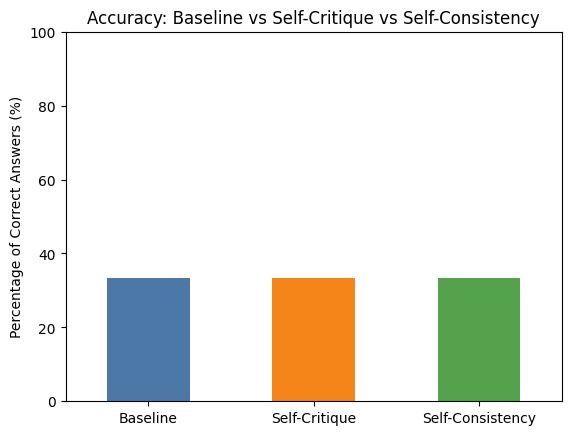

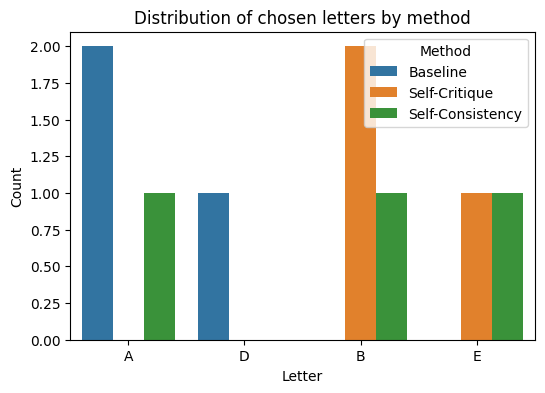

In [101]:

import seaborn as sns
import matplotlib.pyplot as plt

# Przygotowanie kolumn pomocniczych
true = sample_df['answer'].astype(str).str.strip().str.upper()
pred_baseline = sample_df['baseline_answer'].astype(str).str.strip().str.upper()
pred_critique = sample_df['self_critique_answer'].astype(str).str.strip().str.upper()
pred_consistency = sample_df['self_consistency_answer'].astype(str).str.strip().str.upper()

# Dokładność [%] dla każdej metody
acc = {
    'Baseline': (pred_baseline == true).mean() * 100,
    'Self-Critique': (pred_critique == true).mean() * 100,
    'Self-Consistency': (pred_consistency == true).mean() * 100,
}
print("Dokładność [%]:", acc)

pd.Series(acc).plot(kind='bar', color=['#4C78A8','#F58518','#54A24B'])
plt.title('Accuracy: Baseline vs Self-Critique vs Self-Consistency')
plt.ylabel('Percentage of Correct Answers (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.show()



# Rozkład wybieranych liter przez metody
letters_df = pd.DataFrame({
    'Baseline': pred_baseline,
    'Self-Critique': pred_critique,
    'Self-Consistency': pred_consistency,
}).melt(var_name='Method', value_name='Letter')

plt.figure(figsize=(6,4))
sns.countplot(data=letters_df, x='Letter', hue='Method')
plt.title('Distribution of chosen letters by method')
plt.xlabel('Letter')
plt.ylabel('Count')
plt.show()
# ...existing code...

In [105]:
# Liczenie zmian
changes_crit = (pred_critique != pred_baseline)
changes_cons = (pred_consistency != pred_baseline)

# Beneficial / Detrimental
beneficial_crit = ((pred_baseline != true) & (pred_critique == true)).sum()
detrimental_crit = ((pred_baseline == true) & (pred_critique != true)).sum()

beneficial_cons = ((pred_baseline != true) & (pred_consistency == true)).sum()
detrimental_cons = ((pred_baseline == true) & (pred_consistency != true)).sum()

# Opisowy print
print(f"--- Self-Critique ---")
print(f"Liczba przypadków, w których odpowiedź się zmieniła: {changes_crit.sum()} / {len(pred_baseline)} ({changes_crit.mean()*100:.1f}%)")
print(f"Liczba zmian korzystnych (baseline był błędny, nowa odpowiedź poprawna): {beneficial_crit}")
print(f"Liczba zmian szkodliwych (baseline był poprawny, nowa odpowiedź błędna): {detrimental_crit}\n")

print(f"--- Self-Consistency ---")
print(f"Liczba przypadków, w których odpowiedź się zmieniła: {changes_cons.sum()} / {len(pred_baseline)} ({changes_cons.mean()*100:.1f}%)")
print(f"Liczba zmian korzystnych (baseline był błędny, nowa odpowiedź poprawna): {beneficial_cons}")
print(f"Liczba zmian szkodliwych (baseline był poprawny, nowa odpowiedź błędna): {detrimental_cons}")


--- Self-Critique ---
Liczba przypadków, w których odpowiedź się zmieniła: 3 / 3 (100.0%)
Liczba zmian korzystnych (baseline był błędny, nowa odpowiedź poprawna): 1
Liczba zmian szkodliwych (baseline był poprawny, nowa odpowiedź błędna): 1

--- Self-Consistency ---
Liczba przypadków, w których odpowiedź się zmieniła: 2 / 3 (66.7%)
Liczba zmian korzystnych (baseline był błędny, nowa odpowiedź poprawna): 1
Liczba zmian szkodliwych (baseline był poprawny, nowa odpowiedź błędna): 1
